# LDA(Linear discriminant analysis)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

In [2]:
#%% md

# 数据获取

#%%

# 读取数据（）
df_wine = pd.read_csv('wine.data',header=None)
print(df_wine.head())

   0      1     2     3     4    5     6     7     8     9     10    11    12  \
0   1  14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29  5.64  1.04  3.92   
1   1  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28  4.38  1.05  3.40   
2   1  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81  5.68  1.03  3.17   
3   1  14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18  7.80  0.86  3.45   
4   1  13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82  4.32  1.04  2.93   

     13  
0  1065  
1  1050  
2  1185  
3  1480  
4   735  


In [3]:
#%%

# 设置列索引
df_wine.columns =  ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']


# 数据集划分

In [4]:
# 数据集设置：X为样本特征数据，y为目标数据，即标注结果
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

In [5]:
# 数据集划分： 将数据集划分为训练集和测试集数据（测试集数据为30%，训练集为70%）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y,
                                                    random_state=0)

# 数据标准化

In [6]:
# 实例化 准备标准化
sc = StandardScaler()

In [11]:
# 对数据集进行标准化（一般情况下我们在训练集中进行均值和方差的计算，直接在测试集中使用）
X_train_std = sc.fit_transform(X_train)
print(X_train_std)
X_test_std = sc.transform(X_test)

[[ 0.7123  2.2205 -0.1303 ... -0.2002 -0.8216 -0.6295]
 [ 0.8823 -0.7046  1.1753 ...  1.3398  0.5493  1.4757]
 [ 0.8459 -0.7302  1.1753 ...  1.0681  0.1308  1.6293]
 ...
 [ 1.028   2.2975 -0.5779 ... -1.6949 -1.8607 -1.0443]
 [-1.3038 -1.0809 -0.3168 ...  0.1622  0.7369  0.4031]
 [-0.4051  1.2968  0.0563 ...  1.0681  0.7369 -0.8968]]


## LDA实现

In [8]:
# 精度设置,浮点数
np.set_printoptions(precision=4)

### 平均向量

In [13]:
# 计算每一类数据的平均向量，这个是用来求协方差的，即用来计算类内散度矩阵，同时类间散度矩阵的计算也需要
mean_vecs = []
print(X_train_std.shape)
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))   #(124, 13)--->(1,13)  又因为是一列，则自动转化为一维数组向量--->(13,)
    print('MV %s: %s\n' % (label, mean_vecs[label-1]))
    print(mean_vecs[label-1].shape)

(124, 13)
MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

(13,)
MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

(13,)
MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]

(13,)


### 类内散度矩阵$S_W$
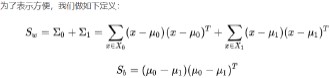

In [15]:
# 特征维度
d = 13
S_W = np.zeros((d, d))
# 获取每个类别的平均值向量
for label, mv in zip(range(1, 4), mean_vecs):
    # 每一类别的散度矩阵
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        # 列向量
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    # 每个类别散度矩阵之和
    S_W += class_scatter
print(S_W)

[[ 5.0722e+01  3.1007e+00 -7.9323e+00 -5.7848e+00 -2.8879e+00  7.8990e+00
   2.4543e+00  9.3932e-01  9.0781e-01  1.5486e+01  7.0293e+00 -1.8659e+00
   4.9370e+00]
 [ 3.1007e+00  9.0179e+01  4.7074e+00  1.4750e+01 -1.0900e+01 -8.8059e-02
   9.7797e-01  8.4547e+00  4.4732e+00 -1.4494e+01 -2.0361e+01  3.5876e+00
  -1.1176e+01]
 [-7.9323e+00  4.7074e+00  1.1189e+02  7.0126e+01  2.2213e+01  1.5505e+01
   1.4856e+01  2.0454e+01 -2.3344e+00  1.3787e+00  5.6585e+00  8.1917e+00
   3.2570e-01]
 [-5.7848e+00  1.4750e+01  7.0126e+01  9.2147e+01  1.2485e+01  6.2091e+00
   6.2783e+00  1.2735e+01 -4.7597e+00 -4.1511e+00  1.1779e+00  1.1633e+01
  -4.5296e+00]
 [-2.8879e+00 -1.0900e+01  2.2213e+01  1.2485e+01  1.0605e+02  1.0950e+01
   5.2875e+00 -2.1136e+01  1.3076e+01  5.9930e+00  8.4568e+00 -5.3128e-01
   1.1845e+01]
 [ 7.8990e+00 -8.8059e-02  1.5505e+01  6.2091e+00  1.0950e+01  5.7194e+01
   2.8971e+01 -7.4850e+00  3.0810e+01  1.5516e+01  6.6816e-01  1.9382e+01
   6.3808e+00]
 [ 2.4543e+00  9.7797e

### 类间散度矩阵$S_B$
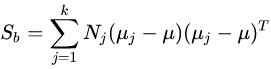

In [17]:
# 这里和类间散度矩阵的定义不一样哈 ，不知道怎么回事
# 全局平均值
mean_overall = np.mean(X_train_std, axis=0)
print(mean_overall)
# 特征维度
d = 13
S_B = np.zeros((d, d))
# 获取每个类别的平均值 ，mean_vecs每一类数据的平均向量，前面求过了
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    # 列向量
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    # 类间散度矩阵
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

[ 6.8901e-15  1.6832e-16  3.7997e-15  2.8561e-16 -3.1785e-16  1.6626e-15
  1.5982e-16 -1.1989e-15  1.8883e-15 -1.6152e-15 -5.7839e-16  8.6311e-16
 -1.3341e-16]


### 特征值计算

求解矩阵 $S_W^{-1}S_B$的特征值和特征向量

In [18]:
# 计算LDA的特征值
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [27]:
eigen_vals.shape,eigen_vecs.shape

((13,), (13, 13))

### 特征值分布

In [28]:
# 创建由特征值和特征向量组成的list
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# 根据特征值从大到小排序(eigenvalue, eigenvector)
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# 特征值结果
for eigen_val in eigen_pairs:
    print(eigen_val[0])

8.262493673957486
4.225659486916688
1.0528816291206889e-15
8.881784197001252e-16
4.899094033918741e-16
4.899094033918741e-16
4.459087001584629e-16
3.7475856725614787e-16
3.7408464699083565e-16
3.7408464699083565e-16
2.819199765804213e-16
8.058442121308179e-17
4.534449124261265e-17


[-8.8818e-16  4.2257e+00  8.2625e+00 -1.0529e-15  3.0433e-16  3.0433e-16
  4.4591e-16  3.7476e-16 -3.2041e-16 -3.2041e-16 -2.8192e-16  4.5344e-17
 -8.0584e-17]
[-8.8818e-16+0.0000e+00j  4.2257e+00+0.0000e+00j  8.2625e+00+0.0000e+00j
 -1.0529e-15+0.0000e+00j  3.0433e-16+3.8392e-16j  3.0433e-16-3.8392e-16j
  4.4591e-16+0.0000e+00j  3.7476e-16+0.0000e+00j -3.2041e-16+1.9306e-16j
 -3.2041e-16-1.9306e-16j -2.8192e-16+0.0000e+00j  4.5344e-17+0.0000e+00j
 -8.0584e-17+0.0000e+00j]


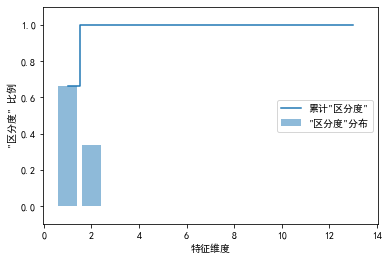

In [34]:
# 实部求和
tot = sum(eigen_vals.real)

print(eigen_vals.real)
print(eigen_vals)
# eigen_vals.real取数的实部，舍去虚部
# 计算比例
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]

# 累计求和
cum_discr = np.cumsum(discr)

# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='"区分度"分布')
plt.step(range(1, 14), cum_discr, where='mid',
         label='累计"区分度"')
plt.ylabel('"区分度" 比例')
plt.xlabel('特征维度')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

### 特征降维

In [35]:
# 保留两维特征
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))

In [31]:
w

array([[-0.1586, -0.4077],
       [ 0.0984, -0.1821],
       [-0.0156, -0.3473],
       [ 0.1588,  0.3095],
       [-0.0207, -0.064 ],
       [ 0.1884,  0.0733],
       [-0.7153,  0.3034],
       [-0.0798, -0.0009],
       [ 0.0074,  0.0716],
       [ 0.3448, -0.2808],
       [-0.0254,  0.244 ],
       [-0.3192, -0.0459],
       [-0.4054, -0.5806]])

In [36]:
# 特征降维
X_train_lda = X_train_std.dot(w)

In [37]:
# 降维前
X_test_std[0]

array([ 0.8944, -0.3881,  1.1007, -0.812 ,  1.132 ,  1.0981,  0.712 ,
        0.181 ,  0.0663,  0.5129,  0.7963,  0.4483,  1.9059])

In [38]:
# 降维后
X_train_lda[0]

array([ 1.2617, -0.6537])

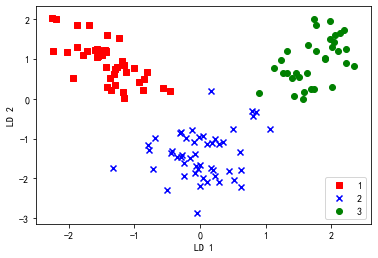

In [39]:
# 结果绘制
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

## 使用sklearn实现LDA并进行LR分类

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# 实例化
lda = LDA(n_components=2)

In [42]:
# 对训练数据进行LDA处理
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [43]:
X_train_lda[0]

array([2.9646, 1.157 ])

In [44]:
# 实例化逻辑回归
lr = LogisticRegression()
# 训练
lr = lr.fit(X_train_lda, y_train)

D:\APP\Anaconda3\py37\tensorflow-gpu\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\APP\Anaconda3\py37\tensorflow-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [46]:
# 绘制样本及其目标值
def plot_decision_regions(X, y, classifier, resolution=0.02):
    """
    X:样本特征值
    y:目标值
    classifier: 分类器
    """
    # 设置图像的标记及颜色
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 利用样本点创建meshgrid
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # 预测结果
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    # 绘制预测结果的等高线
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 绘制样本点,并根据真实值进行着色
    for idx, cl in enumerate(np.unique(y)):
        # 绘制散点图
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


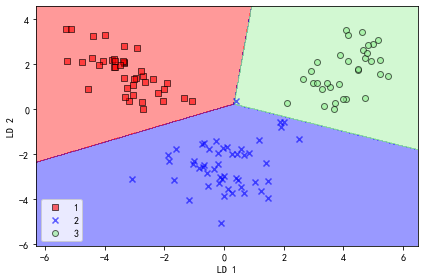

In [47]:
# 训练数据结果
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


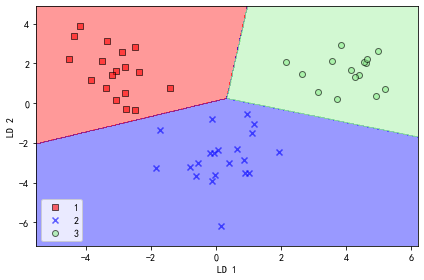

In [48]:
# 测试数据结果
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()